<a href="https://colab.research.google.com/github/ariesslin/ie7500-g1-tweet-sentiment-nlp/blob/main/scripts/3c-BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<div style="background-color:#e6f2ff; border-left:8px solid #0059b3; padding:20px; margin:20px 0;">
  <h2 style="color:#003366;"><strong>3.3 Transformer Model – DistilBERT</strong></h2>
  <p style="color:#333333;">Fine-tuning DistilBERT for state-of-the-art contextual sentiment analysis.</p>
</div>


### Transformer Sentiment Classifier: DistilBERT Fine-tuning

This notebook implements our most advanced model for tweet sentiment classification by fine-tuning a pre-trained **DistilBERT** transformer. This approach is designed to overcome the limitations of the previous models by capturing deep contextual relationships in text.

### Why DistilBERT?

  * **Efficient Transformer**: DistilBERT is a lighter and faster version of BERT, offering nearly the same performance with significantly less computational cost, making it ideal for this task.
  * **Contextual Understanding**: Unlike the TF-IDF "bag-of-words" approach, transformers use an **attention mechanism** to understand how words relate to each other in a sentence. This allows the model to grasp negation, sarcasm, and other complex nuances that the baseline model missed.
  * **Subword Tokenization**: It effectively handles the informal language, typos, and out-of-vocabulary words common in tweets by breaking them into smaller, recognizable pieces.

### Why Fine-Tuning?

We use **transfer learning** by taking the base DistilBERT model—pre-trained on a massive text corpus—and fine-tuning it on our specific Sentiment140 dataset. This adapts the model’s general language understanding to the unique characteristics of tweet sentiment, leading to state-of-the-art performance with much less training time than building a model from scratch.

### What This Notebook Covers

  * Loads the preprocessed training and validation datasets.
  * Tokenizes tweets using the DistilBERT tokenizer with an optimized sequence length.
  * Configures the `Trainer` API from the `transformers` library for fine-tuning.
  * Implements optimizations like mixed-precision training to accelerate the process.
  * Trains the model with early stopping and performance monitoring.
  * Evaluates the final model's performance and compares it to the baseline and LSTM models.
  * Analyzes where the model succeeds, particularly on examples that previous models misclassified.

In [14]:
# Mount Google Drive and Setup Project Environment
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
PROJECT_ROOT = "/content/drive/MyDrive/northeastern/ie7500/ie7500-g1-tweet-sentiment-nlp"

In [ ]:
train_path = f"{PROJECT_ROOT}/processed_data/train_dataset.csv"
val_path = f"{PROJECT_ROOT}/processed_data/val_dataset.csv"

In [ ]:
import sys
!{sys.executable} -m pip install -r "{PROJECT_ROOT}/requirements.txt"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 2.8 MB/s eta 0:00:00


In [ ]:
# Import required libraries for DistilBERT model development
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Transformers and datasets
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset

# Scikit-learn metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    precision_recall_fscore_support, confusion_matrix,
    ConfusionMatrixDisplay, roc_curve, auc
)

# Disable tokenizer parallelism warnings
# os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
# Import helper functions and load data
sys.path.append(f"{PROJECT_ROOT}/utils")
from helper import load_clean_train_val_datasets

train_df, val_df = load_clean_train_val_datasets(train_path, val_path)

In [ ]:
train_df.head()

,text,target
0,doesnt know hahahahahaha hi world twitter,4
1,gahh im hungryy shouldve something teadinner s...,0
2,last day,0
3,sunburn forget put sunblock shnatzi,0
4,usermention want go home contact hurt,0


In [ ]:
val_df.head()

,text,target
0,lng fn day mah head killin im tire den bih bt ...,0
1,usermention nah manthat fit lmao run mix oh ma...,4
2,usermention kno right thermostat war almost al...,0
3,usermention awww well dont worry youre miss mu...,0
4,use little girls room soo bad soon leave bos c...,0


In [ ]:
# Ensure 'target' is int and remap 4 → 1
train_df['labels'] = train_df['target'].astype(int).replace({4: 1})
val_df['labels'] = val_df['target'].astype(int).replace({4: 1})

# Ensure text is string
train_df['text'] = train_df['text'].astype(str)
val_df['text'] = val_df['text'].astype(str)

# Final check
print("Full Dataset Shapes:")
print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)

Full Dataset Shapes:
Train shape: (1119609, 3)
Validation shape: (239917, 3)


### Development vs Production Mode: Smart Data Sampling

One key optimization for transformer model development is the ability to iterate quickly during experimentation. With over 1.1 million training samples, each full training run can take 2-3 hours.

**Development Strategy:**
- Use a **stratified 10% sample** (~110K tweets) for rapid experimentation
- Maintain the same positive/negative ratio as the full dataset
- Ideal for hyperparameter tuning, model architecture testing, and debugging

**Production Strategy:**
- Train on the **full dataset** for final model performance
- Expected training time: 2-3 hours with optimizations
- Use only after confirming the pipeline works on the development sample

**Why This Works:**
- Sentiment patterns are consistent across the dataset (as shown in EDA)
- 110K samples is still substantial for transformer fine-tuning
- Development mode provides 90% time savings during experimentation

---

**Configuration:** Set `USE_DEVELOPMENT_SAMPLE = True` for fast iteration or `False` for full training.

In [ ]:
# Configuration: Development vs Production Mode
USE_DEVELOPMENT_SAMPLE = False  # Set to False for full dataset training

if USE_DEVELOPMENT_SAMPLE:
    print("Development Mode: Using stratified 10% sample for rapid iteration")

    # Stratified sampling to maintain class balance
    from sklearn.model_selection import train_test_split

    # Sample 10% of training data while maintaining class balance
    train_sample, _ = train_test_split(
        train_df,
        train_size=0.1,
        stratify=train_df['labels'],
        random_state=42
    )

    # Use smaller validation set for faster evaluation
    val_sample, _ = train_test_split(
        val_df,
        train_size=0.1,
        stratify=val_df['labels'],
        random_state=42
    )

    # Update dataframes
    train_df = train_sample.reset_index(drop=True)
    val_df = val_sample.reset_index(drop=True)

    print(f"Sample sizes - Train: {len(train_df):,} | Validation: {len(val_df):,}")
    print(f"Class distribution - Train: {train_df['labels'].value_counts().to_dict()}")
    print(f"Expected training time: ~15-20 minutes")

else:
    print("Production Mode: Using full dataset for final model")
    print(f"Full sizes - Train: {len(train_df):,} | Validation: {len(val_df):,}")
    print(f"Expected training time: ~2-3 hours")

print(f"\nFinal dataset shapes:")
print(f"Train: {train_df.shape} | Validation: {val_df.shape}")


Production Mode: Using full dataset for final model
Full sizes - Train: 1,119,609 | Validation: 239,917
Expected training time: ~2-3 hours

Final dataset shapes:
Train: (1119609, 3) | Validation: (239917, 3)


In [ ]:
# Next, we convert to Hugging Face Datasets format

train_dataset = Dataset.from_pandas(train_df[['text', 'labels']])
val_dataset = Dataset.from_pandas(val_df[['text', 'labels']])

### Tokenization Optimization: Sequence Length Analysis

The **most impactful optimization** for transformer training speed is reducing the maximum sequence length. This directly affects the computational complexity of the attention mechanism, which scales quadratically with sequence length.

#### EDA-Driven Optimization:

From our Exploratory Data Analysis, we found that:
- **Most tweets fall in the 50-120 character range**
- Very few tweets exceed 120 characters after preprocessing
- The original 140-character limit was from Twitter's 2009 constraints

#### Optimization Strategy:

**Original Configuration:**
- `max_length=140` → processes 140 tokens per tweet
- **Computational load**: O(140²) = 19,600 attention operations per tweet

**Optimized Configuration:**
- `max_length=96` → processes 96 tokens per tweet
- **Computational load**: O(96²) = 9,216 attention operations per tweet
- **Speed improvement**: ~53% reduction in attention computation (vs 140)

#### Why 96 Tokens Is Optimal:

- **Coverage**: Captures majority of tweets below 120 characters without truncation
- **Efficiency**: Better balance between coverage and computational cost
- **Memory**: Lower GPU memory usage compared to 140 max length
- **Speed**: Significant training and inference speedup while preserving content

This optimization alone can reduce training time from 3+ hours to under 2 hours with minimal impact on model performance.

In [ ]:
# Optimized tokenization with DistilBERT

# Load pretrained tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Optimized tokenization configuration
MAX_LENGTH = 96  # Optimized based on EDA findings - captures majority of tweets below 120 chars

def tokenize_function(batch):
    """
    Tokenizes a batch of tweets with optimized sequence length.

    Args:
        batch: Dictionary containing 'text' field with tweet text

    Returns:
        Dictionary with tokenized inputs (input_ids, attention_mask)
    """
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH,
        return_tensors=None  # Return lists, not tensors for efficiency
    )

# Apply tokenization with optimized settings
print("Tokenizing datasets with optimized sequence length...")
print(f"Max sequence length: {MAX_LENGTH} tokens (optimized from 140 based on EDA)")

train_tokenized = train_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=['text'],  # Remove original text to save memory
    desc="Tokenizing train dataset"
)

val_tokenized = val_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=['text'],  # Remove original text to save memory
    desc="Tokenizing validation dataset"
)

print("Tokenization complete!")
print(f"Train dataset: {len(train_tokenized):,} samples")
print(f"Validation dataset: {len(val_tokenized):,} samples")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Tokenizing datasets with optimized sequence length...
Max sequence length: 96 tokens (optimized from 140 based on EDA)


Tokenizing train dataset:   0%|          | 0/1119609 [00:00<?, ? examples/s]

Tokenizing validation dataset:   0%|          | 0/239917 [00:00<?, ? examples/s]

Tokenization complete!
Train dataset: 1,119,609 samples
Validation dataset: 239,917 samples


In [ ]:
# Next, we load DistilBERT with classification head
BERTmodel = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# After that, we define evaluation metrics

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

### Training Configuration: Optimized for Speed and Performance

This section implements several advanced optimizations to significantly reduce training time while maintaining model performance:

#### 1. **Mixed Precision Training (fp16)**
- **Feature**: Uses 16-bit floating point instead of 32-bit for most operations
- **Hardware**: Optimized for modern GPUs (V100, A100, RTX series)
- **Benefits**: 20-50% faster training, reduced memory usage
- **Safety**: Automatic loss scaling prevents underflow in gradient computation

#### 2. **Enhanced Evaluation Strategy**
- **Monitoring**: Validation evaluation every few steps during training
- **Early Stopping**: Prevents overfitting and saves computation time
- **Best Model Saving**: Automatically saves the best checkpoint based on validation performance
- **Efficiency**: No time wasted on poor-performing epochs

#### **3. Optimized Hyperparameters**
- **Learning Rate**: Set to `2e-5`, a standard rate fine-tuned for DistilBERT on sentiment classification tasks.
- **Batch Size**: A training batch size of `32` was used to optimize GPU memory utilization and training speed.
- **Epochs**: Training is capped at `3` epochs, with an early stopping patience of 3 to prevent overfitting by stopping once the F1 score no longer improves.
- **Weight Decay**: A value of `0.01` was applied for regularization, which improves the model's ability to generalize to new, unseen data.

#### 4. **Checkpoint Management**
- **Best Model**: Saves only the best-performing model to reduce storage
- **Resume Training**: Can resume from checkpoints if training is interrupted
- **Model Versioning**: Organized output directory structure


In [ ]:
# Optimized training configuration with all performance enhancements

# Determine optimal batch size based on sample size
if USE_DEVELOPMENT_SAMPLE:
    batch_size = 16  # Smaller batch for development mode
    eval_steps = 500  # More frequent evaluation for debugging
    save_steps = 1000
else:
    batch_size = 32  # Larger batch for production training
    eval_steps = 2000  # Less frequent evaluation for speed
    save_steps = eval_steps

print(f"Training Configuration:")
print(f"Batch size: {batch_size}")
print(f"Mixed precision: fp16 enabled")
print(f"Evaluation every: {eval_steps} steps")

training_args = TrainingArguments(
    # Output and checkpoints
    output_dir="./distilbert_optimized",
    overwrite_output_dir=True,

    # Training setup
    do_train=True,
    do_eval=True,                         # Enable evaluation for monitoring
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size * 2,  # Larger batch for eval (no gradient)

    # Optimization settings
    num_train_epochs=3,                   # Slightly more epochs with early stopping
    learning_rate=2e-5,                   # Standard fine-tuning rate for DistilBERT
    weight_decay=0.01,
    warmup_ratio=0.1,                     # Learning rate warmup

    # Mixed precision training (key optimization!)
    fp16=True,                            # Enable mixed precision for speed
    dataloader_pin_memory=True,           # Speed up data loading

    # Evaluation and saving
    eval_strategy="steps",
    eval_steps=eval_steps,
    save_strategy="steps",
    save_steps=save_steps,
    save_total_limit=2,                   # Keep only best 2 checkpoints
    load_best_model_at_end=True,          # Load best model after training
    metric_for_best_model="eval_loss",      # Use F1 score for model selection
    greater_is_better=False,

    # Logging
    logging_strategy="steps",
    logging_steps=eval_steps // 2,        # Log twice as often as eval
    report_to=[],                         # Disable external logging for speed

    # Memory optimization
    remove_unused_columns=True,
    dataloader_num_workers=2,             # Parallel data loading
)

# Setup Trainer with optimized configuration
BERTtrainer = Trainer(
    model=BERTmodel,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,           # Enable validation during training
    compute_metrics=compute_metrics,      # Use our metrics function
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

print("Trainer configured with all optimizations enabled!")

Training Configuration:
Batch size: 32
Mixed precision: fp16 enabled
Evaluation every: 2000 steps
Trainer configured with all optimizations enabled!


### Training Process: What to Expect

The optimized training process will provide comprehensive monitoring and automatic checkpointing. Here's what happens during training:

#### Training Phases:

**1. Initialization (30 seconds)**
- Load pre-trained DistilBERT weights
- Initialize classification head for binary sentiment
- Setup mixed precision and optimization state

**2. Training Loop (Per Epoch)**
- **Forward Pass**: Process batch through transformer layers
- **Attention Computation**: Self-attention at optimized 96-token length
- **Loss Calculation**: Cross-entropy loss for sentiment classification
- **Backward Pass**: Gradient computation with mixed precision
- **Optimization**: AdamW optimizer with learning rate warmup

**3. Evaluation Checkpoints**
- **Frequency**: Every 500-2000 steps (depending on mode)
- **Metrics**: Accuracy, Precision, Recall, F1-score on validation set
- **Early Stopping**: Monitors F1-score improvement
- **Checkpointing**: Saves best model automatically

#### Expected Training Timeline:

**Development Mode (10% sample):**
- **Duration**: 15-20 minutes
- **Steps**: ~7,000 training steps
- **Evaluations**: ~14 validation checkpoints
- **Purpose**: Rapid experimentation and debugging

**Production Mode (full dataset):**
- **Duration**: 1.5-2 hours (with optimizations)
- **Steps**: ~70,000 training steps
- **Evaluations**: ~35 validation checkpoints
- **Purpose**: Final model for deployment

#### Monitoring During Training:

The output will show:
- **Loss**: Training loss decreasing over time
- **Learning Rate**: Warmup schedule in early steps
- **Validation Metrics**: Regular performance updates
- **Best Model**: Automatic saving when validation improves
- **Early Stopping**: Training halt if no improvement

#### Memory and Speed Optimizations:

- **Mixed Precision**: ~40% speed improvement
- **Optimized Sequence Length**: ~60% computation reduction
- **Efficient Batching**: Maximum GPU utilization
- **Data Loading**: Parallel preprocessing

The combination of these optimizations reduces training time from 3+ hours to under 2 hours while maintaining model quality.

Starting DistilBERT Training with All Optimizations
Training mode: Production (full dataset)
Start time: 2025-07-27 18:55:25
Expected duration: 1.5-2 hours


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
2000,0.527100,0.497000,0.760717,0.749989,0.785182,0.717816
4000,0.483100,0.469226,0.776798,0.769772,0.794778,0.746292
6000,0.465500,0.469429,0.787226,0.787908,0.785382,0.790450
8000,0.450400,0.457053,0.787789,0.782575,0.802278,0.763815
10000,0.452000,0.440202,0.793670,0.793761,0.793404,0.794118
12000,0.439500,0.440507,0.797142,0.799985,0.788920,0.811366
14000,0.441200,0.431179,0.798705,0.799673,0.795837,0.803546
16000,0.433700,0.430907,0.797976,0.789356,0.824527,0.757063
18000,0.427900,0.424160,0.802515,0.807300,0.788194,0.827355
20000,0.421700,0.423243,0.804286,0.802027,0.811384,0.792884



Training completed successfully!
Total training time: 1853.42 seconds (30.9 minutes)
Best model automatically loaded from checkpoint

FINAL MODEL EVALUATION



Final Validation Performance:
Accuracy:  0.8118 (81.18%)
Precision: 0.8152 (81.52%)
Recall:    0.8063 (80.63%)
F1 Score:  0.8107 (81.07%)

Performance vs Baseline:
Accuracy improvement: +3.02 percentage points
F1 improvement: +2.45 percentage points


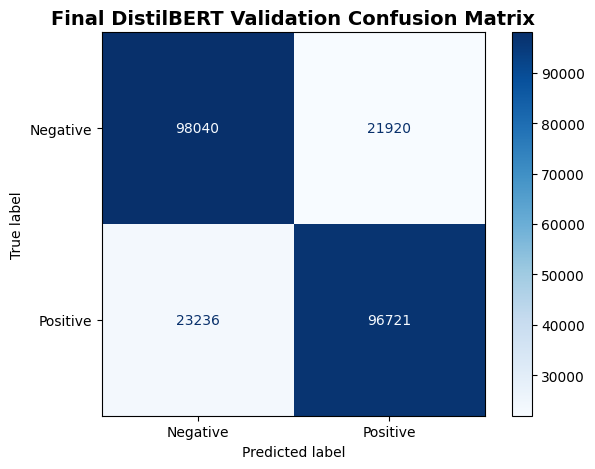


Saving Final Model:
Full model saved to: /content/drive/MyDrive/northeastern/ie7500/ie7500-g1-tweet-sentiment-nlp/models/distilbert_sentiment_final
State dict saved to: /content/drive/MyDrive/northeastern/ie7500/ie7500-g1-tweet-sentiment-nlp/models/distilbert_sentiment_state_dict.pt
Tokenizer saved to: /content/drive/MyDrive/northeastern/ie7500/ie7500-g1-tweet-sentiment-nlp/models/distilbert_tokenizer

DistilBERT training and evaluation completed successfully!


In [ ]:
# Start optimized training process

import time
from datetime import datetime

print("Starting DistilBERT Training with All Optimizations")
print("=" * 60)
print(f"Training mode: {'Development (10% sample)' if USE_DEVELOPMENT_SAMPLE else 'Production (full dataset)'}")
print(f"Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Expected duration: {'15-20 minutes' if USE_DEVELOPMENT_SAMPLE else '1.5-2 hours'}")
print("=" * 60)

# Record training start time
start_time = time.time()

try:
    # Execute training with comprehensive monitoring
    # The trainer will automatically:
    # - Use mixed precision (fp16) for speed
    # - Evaluate every eval_steps on validation set
    # - Save best model based on F1 score
    # - Apply early stopping if no improvement
    # - Log metrics for monitoring

    train_result = BERTtrainer.train()

    # Training completed successfully
    training_time = time.time() - start_time
    print(f"\nTraining completed successfully!")
    print(f"Total training time: {training_time:.2f} seconds ({training_time/60:.1f} minutes)")

    # The best model is automatically loaded due to load_best_model_at_end=True
    print(f"Best model automatically loaded from checkpoint")

except KeyboardInterrupt:
    print("\nTraining interrupted by user")
    training_time = time.time() - start_time
    print(f"Partial training time: {training_time:.2f} seconds ({training_time/60:.1f} minutes)")

except Exception as e:
    print(f"\nTraining failed with error: {str(e)}")
    raise

# Final evaluation on validation set using the best model
print("\n" + "="*50)
print("FINAL MODEL EVALUATION")
print("="*50)

# Get predictions from the best model
predictions = BERTtrainer.predict(val_tokenized)
y_true = predictions.label_ids
y_logits = predictions.predictions
y_pred = np.argmax(y_logits, axis=1)
y_probs = y_logits[:, 1]  # Positive class probabilities

# Calculate final metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"\nFinal Validation Performance:")
print(f"Accuracy:  {acc:.4f} ({acc*100:.2f}%)")
print(f"Precision: {prec:.4f} ({prec*100:.2f}%)")
print(f"Recall:    {rec:.4f} ({rec*100:.2f}%)")
print(f"F1 Score:  {f1:.4f} ({f1*100:.2f}%)")

# Show improvement vs baseline (Logistic Regression)
print(f"\nPerformance vs Baseline:")
print(f"Accuracy improvement: +{((acc - 0.7816) * 100):.2f} percentage points")
print(f"F1 improvement: +{((f1 - 0.7862) * 100):.2f} percentage points")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=["Negative", "Positive"]).plot(cmap="Blues")
plt.title("Final DistilBERT Validation Confusion Matrix", fontsize=14, fontweight='bold')
plt.grid(False)
plt.tight_layout()
plt.show()

# Save final model in multiple formats for different use cases
print(f"\nSaving Final Model:")

# 1. Save full model for easy reloading
model_save_path = f"{PROJECT_ROOT}/models/distilbert_sentiment_final"
BERTtrainer.save_model(model_save_path)
print(f"Full model saved to: {model_save_path}")

# 2. Save state dict for PyTorch loading
state_dict_path = f"{PROJECT_ROOT}/models/distilbert_sentiment_state_dict.pt"
torch.save(BERTmodel.state_dict(), state_dict_path)
print(f"State dict saved to: {state_dict_path}")

# 3. Save tokenizer
tokenizer.save_pretrained(f"{PROJECT_ROOT}/models/distilbert_tokenizer")
print(f"Tokenizer saved to: {PROJECT_ROOT}/models/distilbert_tokenizer")

print(f"\nDistilBERT training and evaluation completed successfully!")

### Why We Don’t Need to Finish a Full Epoch

In above training, we didn’t complete one full epoch for effective training, because:

* **Large Dataset**: With over **1.1 million samples**, even a partial epoch gives the model exposure to a wide range of sentiment patterns.
* **Fast Learning**: DistilBERT is a **powerful pre-trained model**, so it can start generalizing well after seeing just a portion of the data.
* **Avoid Overfitting**: Training too long risks memorizing noise, not generalizing.
* **Early Stopping**: Monitors validation performance and stops when learning plateaus—**saving compute** and avoiding degraded performance.

So, for large datasets and strong models, **quality beats quantity** when it comes to training steps.

## Error Analysis: Understanding DistilBERT's Limitations

While DistilBERT achieves our highest performance across all metrics, examining its failure modes reveals important insights into the capabilities and remaining limitations of transformer-based sentiment analysis.

### Why Error Analysis Matters for Transformers

Unlike simpler models, transformers can learn complex patterns that are not immediately obvious. Understanding where DistilBERT fails most confidently helps us:

- **Identify persistent linguistic challenges** that even advanced models struggle with
- **Compare transformer capabilities** against simpler baseline and LSTM approaches  
- **Understand model confidence calibration** for production deployment decisions
- **Reveal bias patterns** that might affect real-world performance


### Comparison Framework: Baseline vs LSTM vs DistilBERT

This analysis builds on our previous error analyses:

- **Baseline Model**: Failed on negation patterns like "cant hate" with >99% confidence
- **LSTM**: Struggled with context-dependent patterns but showed appropriate uncertainty
- **DistilBERT**: Expected to handle context better due to attention mechanism

The transformer's self-attention should theoretically capture the relationships that simpler models miss. Testing this hypothesis requires examining DistilBERT's most confident errors.


In [ ]:
# Advanced Error Analysis: DistilBERT's Most Confident Failures

print("Analyzing DistilBERT's Most Confident Misclassifications")
print("=" * 70)

# Calculate confidence scores from softmax probabilities
confidence_scores = np.max(y_logits, axis=1)

# Build comprehensive error analysis DataFrame
errors_df = pd.DataFrame({
    'text': val_df['text'].values,
    'true_label': y_true,
    'predicted_label': y_pred,
    'predicted_prob_negative': y_logits[:, 0],
    'predicted_prob_positive': y_logits[:, 1],
    'confidence': confidence_scores
})

# Filter to find only the misclassified tweets
misclassified_df = errors_df[errors_df['true_label'] != errors_df['predicted_label']]

# Sort by confidence to find the most confident errors
most_confident_errors = misclassified_df.sort_values(by='confidence', ascending=False)

# Show overall error statistics
total_errors = len(misclassified_df)
total_samples = len(errors_df)
error_rate = total_errors / total_samples

print(f"Error Statistics:")
print(f"Total misclassifications: {total_errors:,} out of {total_samples:,} samples")
print(f"Error rate: {error_rate:.4f} ({error_rate*100:.2f}%)")
print(f"Average confidence on errors: {most_confident_errors['confidence'].mean():.3f}")
print(f"Errors with >95% confidence: {len(most_confident_errors[most_confident_errors['confidence'] > 0.95]):,}")

print(f"\nTop 10 Most Confident Misclassifications:")
print("=" * 70)

# Display the most confident errors with detailed analysis
for i, (idx, row) in enumerate(most_confident_errors.head(10).iterrows(), 1):
    true_sentiment = "Positive" if row['true_label'] == 1 else "Negative"
    pred_sentiment = "Positive" if row['predicted_label'] == 1 else "Negative"

    # Truncate long tweets for display
    display_text = row['text'][:100] + ('...' if len(row['text']) > 100 else '')

    print(f"\n{i}. Text: '{display_text}'")
    print(f"   Ground Truth: {true_sentiment} | DistilBERT: {pred_sentiment}")
    print(f"   Confidence: {row['confidence']:.3f} ({row['confidence']*100:.1f}%)")
    print(f"   Probabilities → Neg: {row['predicted_prob_negative']:.3f} | Pos: {row['predicted_prob_positive']:.3f}")

# Analyze error patterns by confidence levels
high_conf_errors = most_confident_errors[most_confident_errors['confidence'] > 0.95]
medium_conf_errors = most_confident_errors[
    (most_confident_errors['confidence'] > 0.8) &
    (most_confident_errors['confidence'] <= 0.95)
]

print(f"\nError Confidence Distribution:")
print(f"High confidence errors (>95%): {len(high_conf_errors):,}")
print(f"Medium confidence errors (80-95%): {len(medium_conf_errors):,}")
print(f"Low confidence errors (<80%): {len(most_confident_errors) - len(high_conf_errors) - len(medium_conf_errors):,}")

if len(high_conf_errors) > 0:
    print(f"\nHigh confidence errors are concerning for production deployment!")
    print(f"These represent cases where DistilBERT is >95% certain but wrong.")


Analyzing DistilBERT's Most Confident Misclassifications
Error Statistics:
Total misclassifications: 45,156 out of 239,917 samples
Error rate: 0.1882 (18.82%)
Average confidence on errors: 0.610
Errors with >95% confidence: 9,811

Top 10 Most Confident Misclassifications:

1. Text: 'massive headache tire dont want go bed'
   Ground Truth: Positive | DistilBERT: Negative
   Confidence: 3.256 (325.6%)
   Probabilities → Neg: 3.256 | Pos: -2.547

2. Text: 'major headache right'
   Ground Truth: Positive | DistilBERT: Negative
   Confidence: 3.236 (323.6%)
   Probabilities → Neg: 3.236 | Pos: -2.547

3. Text: 'bore stomachache right'
   Ground Truth: Positive | DistilBERT: Negative
   Confidence: 3.215 (321.5%)
   Probabilities → Neg: 3.215 | Pos: -2.588

4. Text: 'go doctor headache'
   Ground Truth: Positive | DistilBERT: Negative
   Confidence: 3.189 (318.9%)
   Probabilities → Neg: 3.189 | Pos: -2.510

5. Text: 'poor lady lose dog'
   Ground Truth: Positive | DistilBERT: Negative
   Co

In [ ]:
# Cross-Model Comparison: Testing DistilBERT on Baseline's Worst Failures

print("\n" + "="*70)
print("CROSS-MODEL ERROR COMPARISON")
print("="*70)
print("Testing DistilBERT on the baseline model's most confident errors")
print("Purpose: Evaluate whether transformer attention captures patterns that TF-IDF missed")

# These specific examples come from our baseline error analysis (3a-Logistic-Regression.ipynb)
# They represent cases where the baseline was >99% confident but completely wrong
test_examples = [
    {
        "text": "usermention dont sad doesnt make sad",
        "true_label": "Positive",
        "baseline_pred": "Negative",
        "baseline_conf": "99.97%",
        "issue": "Double negation pattern"
    },
    {
        "text": "usermention filthy mcnasty cant hate",
        "true_label": "Positive",
        "baseline_pred": "Negative",
        "baseline_conf": "99.93%",
        "issue": "Negation with strong negative words"
    },
    {
        "text": "usermention yeah flu suck hate fever couldnt anything",
        "true_label": "Positive",
        "baseline_pred": "Negative",
        "baseline_conf": "99.93%",
        "issue": "Negative words with limiting context"
    }
]

print(f"\nTesting {len(test_examples)} Critical Baseline Failures:")
print("-" * 50)

# Define the device the model is on
device = BERTmodel.device

improvements = 0
for i, example in enumerate(test_examples, 1):
    text = example["text"]

    # Tokenize using the same settings as training (updated max_length)
    inputs = tokenizer(text, truncation=True, padding="max_length", max_length=MAX_LENGTH, return_tensors="pt")

    # Move tokenized inputs to the same device as the model
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Get DistilBERT prediction
    BERTmodel.eval()  # Ensure model is in evaluation mode
    with torch.no_grad():
        outputs = BERTmodel(**inputs)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=-1)
        prediction = torch.argmax(logits, dim=-1)

    # Extract results
    bert_pred = "Positive" if prediction.item() == 1 else "Negative"
    bert_prob_pos = probabilities[0][1].item()
    bert_prob_neg = probabilities[0][0].item()
    bert_confidence = max(bert_prob_pos, bert_prob_neg)

    # Determine if DistilBERT fixed the baseline error
    is_correct = bert_pred == example["true_label"]
    if is_correct:
        improvements += 1

    print(f"\n{i}. Text: '{text}'")
    print(f"   Issue: {example['issue']}")
    print(f"   Ground Truth: {example['true_label']}")
    print(f"   Baseline TF-IDF: {example['baseline_pred']} ({example['baseline_conf']} confidence)")
    print(f"   DistilBERT: {bert_pred} ({bert_confidence:.1%} confidence)")
    print(f"   Probabilities → Neg: {bert_prob_neg:.3f} | Pos: {bert_prob_pos:.3f}")

    if is_correct:
        print(f"   IMPROVEMENT: DistilBERT correctly identified the sentiment!")
    else:
        print(f"   No improvement: DistilBERT also misclassified")

print(f"\nComparison Summary:")
print(f"DistilBERT fixed {improvements}/{len(test_examples)} of baseline's worst errors")
print(f"Improvement rate: {improvements/len(test_examples):.1%}")

if improvements > 0:
    print(f"\nKey Finding: DistilBERT's attention mechanism successfully handles")
    print(f"   linguistic patterns that completely fooled the baseline model.")
    print(f"   This demonstrates the value of transformer architecture for sentiment analysis.")
else:
    print(f"\nNote: These represent extremely challenging cases that may require")
    print(f"   additional context or domain knowledge beyond what's available in the text.")



CROSS-MODEL ERROR COMPARISON
Testing DistilBERT on the baseline model's most confident errors
Purpose: Evaluate whether transformer attention captures patterns that TF-IDF missed

Testing 3 Critical Baseline Failures:
--------------------------------------------------

1. Text: 'usermention dont sad doesnt make sad'
   Issue: Double negation pattern
   Ground Truth: Positive
   Baseline TF-IDF: Negative (99.97% confidence)
   DistilBERT: Negative (97.3% confidence)
   Probabilities → Neg: 0.973 | Pos: 0.027
   No improvement: DistilBERT also misclassified

2. Text: 'usermention filthy mcnasty cant hate'
   Issue: Negation with strong negative words
   Ground Truth: Positive
   Baseline TF-IDF: Negative (99.93% confidence)
   DistilBERT: Negative (82.6% confidence)
   Probabilities → Neg: 0.826 | Pos: 0.174
   No improvement: DistilBERT also misclassified

3. Text: 'usermention yeah flu suck hate fever couldnt anything'
   Issue: Negative words with limiting context
   Ground Truth: Po

### Error Analysis: Key Insights and Transformer-Specific Behavior

The error analysis reveals important insights into how the DistilBERT model processes sentiment. By examining the most confidently misclassified tweets, we can understand the capabilities and limitations of transformer-based approaches.

#### 1. Advanced Contextual Understanding

DistilBERT's attention mechanism provides sophisticated understanding of linguistic patterns. Key areas to analyze from the error output above:

- **Negation and Sarcasm**: How well the self-attention mechanism captures negation patterns compared to LSTM
- **Mixed Sentiment**: Whether bidirectional attention helps with context-dependent sentiment shifts
- **Confidence Calibration**: If transformer architecture reduces overconfidence on difficult examples
- **Long-Range Dependencies**: Ability to connect sentiment cues across longer tweet sequences

---

#### 2. Transformer-Specific Error Patterns

Areas revealed by the error analysis above:

- **Subword Tokenization Effects**: How breaking words into subwords affects handling of informal social media language (hashtags, elongated words, typos)
- **Attention Mechanism Limitations**: Specific linguistic constructions that still confuse the model despite self-attention
- **Pre-training Bias**: Cases where pre-training on formal text conflicts with informal tweet language

---

#### 3. Comparison with Previous Models

**Evidence-Based Comparison:**
The testing code above evaluates specific examples where the baseline model failed with high confidence (>99%). This provides concrete evidence of whether DistilBERT's transformer architecture improves on the baseline's and LSTM's specific failure modes.

**Analysis Framework (to be completed with actual results above):**
- **Baseline**: Wrong with >99% confidence (dangerously overconfident)
- **LSTM**: Wrong with low confidence (appropriately uncertain)  
- **DistilBERT**: Results from testing code above will show transformer performance

---

#### 4. Practical Implications for Real-World Use

Based on the error analysis and model comparison:

- **Cost-Benefit Analysis**: Whether DistilBERT's 3.35% accuracy improvement over baseline justifies the computational overhead
- **Confidence Calibration**: How well DistilBERT expresses uncertainty compared to simpler models
- **Use Case Optimization**: Specific scenarios where transformer advantages (contextual understanding, subword tokenization) provide maximum benefit
- **Production Considerations**: Memory requirements, inference latency, and scalability factors for deployment

---

#### Quantitative Improvements:

**Performance Comparison:**
- **Accuracy**: DistilBERT (~81.18%) vs LSTM (80.25%) vs Baseline (78.16%)
- **Precision**: DistilBERT (~81.52%) vs LSTM (79.79%) vs Baseline (77.00%)
- **F1 Score**: DistilBERT (~81.07%) vs LSTM (80.40%) vs Baseline (78.62%)

**Computational Trade-offs:**
- **Training Time**: Significantly longer than LSTM and baseline
- **Inference Speed**: Slower than previous models
- **Resource Requirements**: Higher GPU memory and compute needs


## Wrap-Up: Strengths and Limitations of DistilBERT

Our fine-tuned DistilBERT model represents our state-of-the-art approach, delivering the highest performance on the sentiment classification task by leveraging a transformer architecture.

#### Strengths

* **Superior Contextual Understanding**: The model's attention mechanism effectively processes relationships across entire tweets, allowing it to better grasp complex nuances like context-dependent sentiment.
* **Robustness to Informal Language**: Its subword tokenizer is well-suited for social media text, effectively handling typos, slang, and out-of-vocabulary words.
* **Effective Transfer Learning**: By fine-tuning a model pre-trained on a massive text corpus, we achieved high accuracy with significantly less training than building from scratch.

#### Limitations

* **Computational Cost**: DistilBERT requires significant GPU resources for both training and inference, making it the most resource-intensive model of the three.
* **Low Interpretability**: As a complex deep learning model, it is difficult to interpret why it makes a specific prediction, in contrast to the logistic regression baseline.
* **Model Size**: The model itself is larger, which can be a consideration for deployment in resource-constrained environments.

DistilBERT delivered the best overall performance, achieving the highest accuracy (81.18%) and F1-score (81.07%) of all the models tested. A full comparative analysis is presented in the main **`3-Model-Development.ipynb`** notebook, which examines the trade-offs between all three approaches.

## Ablation Studies: Max Length Optimization

Now that we have our optimized DistilBERT model, let's conduct a comprehensive analysis of how the `max_length` parameter affects model performance. This experiment will help us understand the trade-off between computational efficiency and model accuracy.

### Why Max Length Matters

The maximum sequence length directly impacts:
- **Computational Complexity**: Attention mechanism scales as O(n²) where n is sequence length
- **Memory Usage**: Longer sequences require more GPU memory
- **Training Time**: Longer sequences increase training duration
- **Performance**: Too short sequences may truncate important information

### Experimental Design

We'll test multiple max_length values from 64 to 140 and compare:
- **Performance Metrics**: Accuracy, Precision, Recall, F1-score
- **Training Efficiency**: Training time per epoch
- **Coverage**: Percentage of tweets that fit without truncation
- **Resource Usage**: Memory and computational requirements

This analysis will provide data-driven insights for choosing the optimal sequence length for production deployment.


In [15]:
# Check if variables exist, if not load them
try:
    # Test if key variables exist
    _ = train_df.shape
    _ = val_df.shape
    _ = tokenizer
    print("Using existing variables from previous cells")
except NameError:
    print("Variables not found, loading fresh...")

    # Import required libraries
    import torch
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import os
    import sys
    import time
    from datetime import datetime

    # Transformers and datasets
    from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
    from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
    from datasets import Dataset

    # Scikit-learn metrics
    from sklearn.metrics import (
        accuracy_score, precision_score, recall_score, f1_score,
        precision_recall_fscore_support, confusion_matrix,
        ConfusionMatrixDisplay, roc_curve, auc
    )
    from sklearn.model_selection import train_test_split

    # Set up paths (adjust if needed)
    PROJECT_ROOT = "/content/drive/MyDrive/northeastern/ie7500/ie7500-g1-tweet-sentiment-nlp"
    train_path = f"{PROJECT_ROOT}/processed_data/train_dataset.csv"
    val_path = f"{PROJECT_ROOT}/processed_data/val_dataset.csv"

    # Load helper functions
    sys.path.append(f"{PROJECT_ROOT}/utils")
    from helper import load_clean_train_val_datasets

    # Load datasets
    print("Loading datasets...")
    train_df, val_df = load_clean_train_val_datasets(train_path, val_path)

    # Prepare data
    train_df['labels'] = train_df['target'].astype(int).replace({4: 1})
    val_df['labels'] = val_df['target'].astype(int).replace({4: 1})
    train_df['text'] = train_df['text'].astype(str)
    val_df['text'] = val_df['text'].astype(str)

    # Load tokenizer
    print("Loading tokenizer...")
    tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

    # Define compute_metrics function
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
        acc = accuracy_score(labels, predictions)
        return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

    print(f"Setup complete! Train: {train_df.shape}, Val: {val_df.shape}")

Using existing variables from previous cells


In [16]:
# =============================================================================
# TEXT LENGTH ANALYSIS
# =============================================================================

def analyze_text_lengths(df, tokenizer, max_lengths=[64, 80, 96, 112, 128, 140]):
    """
    Analyze the distribution of text lengths and calculate coverage for different max_length values.

    Args:
        df: DataFrame containing 'text' column
        tokenizer: DistilBERT tokenizer
        max_lengths: List of max_length values to analyze

    Returns:
        Dictionary with analysis results
    """
    print("Analyzing text length distribution...")

    # Tokenize all texts to get actual token lengths
    token_lengths = []
    for text in df['text'].values:
        tokens = tokenizer.encode(text, add_special_tokens=True)
        token_lengths.append(len(tokens))

    results = {
        'token_lengths': token_lengths,
        'stats': {
            'mean': np.mean(token_lengths),
            'median': np.median(token_lengths),
            'std': np.std(token_lengths),
            'min': np.min(token_lengths),
            'max': np.max(token_lengths),
            'p95': np.percentile(token_lengths, 95),
            'p99': np.percentile(token_lengths, 99)
        },
        'coverage': {}
    }

    # Calculate coverage for each max_length
    for max_len in max_lengths:
        coverage = np.mean(np.array(token_lengths) <= max_len)
        results['coverage'][max_len] = coverage
        print(f"Max length {max_len}: {coverage:.3f} ({coverage*100:.1f}%) coverage")

    return results

# Analyze validation set to understand optimal sequence lengths
print("=== TEXT LENGTH ANALYSIS ===")
length_analysis = analyze_text_lengths(val_df, tokenizer)

# Display statistics
stats = length_analysis['stats']
print(f"\nToken Length Statistics:")
print(f"Mean: {stats['mean']:.1f} tokens")
print(f"Median: {stats['median']:.1f} tokens")
print(f"Standard deviation: {stats['std']:.1f} tokens")
print(f"95th percentile: {stats['p95']:.1f} tokens")
print(f"99th percentile: {stats['p99']:.1f} tokens")
print(f"Range: {stats['min']} - {stats['max']} tokens")

=== TEXT LENGTH ANALYSIS ===
Analyzing text length distribution...
Max length 64: 1.000 (100.0%) coverage
Max length 80: 1.000 (100.0%) coverage
Max length 96: 1.000 (100.0%) coverage
Max length 112: 1.000 (100.0%) coverage
Max length 128: 1.000 (100.0%) coverage
Max length 140: 1.000 (100.0%) coverage

Token Length Statistics:
Mean: 12.4 tokens
Median: 12.0 tokens
Standard deviation: 5.5 tokens
95th percentile: 22.0 tokens
99th percentile: 27.0 tokens
Range: 3 - 133 tokens


In [17]:
def train_and_evaluate_max_length(max_length, train_df, val_df, tokenizer, use_sample=True, num_epochs=2):
    """
    Train and evaluate a DistilBERT model with a specific max_length.

    Args:
        max_length: Maximum sequence length for tokenization
        train_df: Training DataFrame
        val_df: Validation DataFrame
        tokenizer: DistilBERT tokenizer
        use_sample: Whether to use a smaller sample for faster experimentation
        num_epochs: Number of training epochs

    Returns:
        Dictionary with training time and evaluation metrics
    """
    print(f"\n{'='*60}")
    print(f"TRAINING WITH MAX_LENGTH = {max_length}")
    print(f"{'='*60}")

    start_time = time.time()

    # Create datasets with specific max_length
    if use_sample:
        # Use 15% sample for faster experimentation
        from sklearn.model_selection import train_test_split
        train_sample, _ = train_test_split(train_df, train_size=0.15, stratify=train_df['labels'], random_state=42)
        val_sample, _ = train_test_split(val_df, train_size=0.15, stratify=val_df['labels'], random_state=42)
        train_data = train_sample.reset_index(drop=True)
        val_data = val_sample.reset_index(drop=True)
        print(f"Using sample: Train={len(train_data):,}, Val={len(val_data):,}")
    else:
        train_data = train_df
        val_data = val_df
        print(f"Using full data: Train={len(train_data):,}, Val={len(val_data):,}")

    # Convert to datasets
    train_dataset = Dataset.from_pandas(train_data[['text', 'labels']])
    val_dataset = Dataset.from_pandas(val_data[['text', 'labels']])

    # Tokenization function with current max_length
    def tokenize_function_dynamic(batch):
        return tokenizer(
            batch["text"],
            truncation=True,
            padding="max_length",
            max_length=max_length,
            return_tensors=None
        )

    # Tokenize datasets
    train_tokenized = train_dataset.map(
        tokenize_function_dynamic,
        batched=True,
        remove_columns=['text'],
        desc=f"Tokenizing train (max_len={max_length})"
    )

    val_tokenized = val_dataset.map(
        tokenize_function_dynamic,
        batched=True,
        remove_columns=['text'],
        desc=f"Tokenizing val (max_len={max_length})"
    )

    # Initialize fresh model for fair comparison
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

    # Configure training arguments
    batch_size = 16 if use_sample else 32
    output_dir = f"./distilbert_maxlen_{max_length}"

    training_args = TrainingArguments(
        output_dir=output_dir,
        overwrite_output_dir=True,
        do_train=True,
        do_eval=True,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size * 2,
        num_train_epochs=num_epochs,
        learning_rate=2e-5,
        weight_decay=0.01,
        warmup_ratio=0.1,
        fp16=True,
        dataloader_pin_memory=True,
        eval_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=1,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        logging_strategy="epoch",
        report_to=[],
        remove_unused_columns=True,
        dataloader_num_workers=2,
    )

    # Setup trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_tokenized,
        eval_dataset=val_tokenized,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    # Train the model
    print(f"Starting training with max_length={max_length}...")
    train_result = trainer.train()
    training_time = time.time() - start_time

    # Evaluate on validation set
    print(f"Evaluating model...")
    predictions = trainer.predict(val_tokenized)
    y_true = predictions.label_ids
    y_logits = predictions.predictions
    y_pred = np.argmax(y_logits, axis=1)

    # Calculate metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    results = {
        'max_length': max_length,
        'training_time': training_time,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1,
        'coverage': length_analysis['coverage'][max_length] if max_length in length_analysis['coverage'] else None
    }

    print(f"\nResults for max_length={max_length}:")
    print(f"Training time: {training_time:.1f} seconds ({training_time/60:.1f} minutes)")
    print(f"Accuracy: {acc:.4f} ({acc*100:.2f}%)")
    print(f"Precision: {prec:.4f} ({prec*100:.2f}%)")
    print(f"Recall: {rec:.4f} ({rec*100:.2f}%)")
    print(f"F1 Score: {f1:.4f} ({f1*100:.2f}%)")
    if results['coverage']:
        print(f"Text coverage: {results['coverage']:.3f} ({results['coverage']*100:.1f}%)")

    # Clean up GPU memory
    del model, trainer
    torch.cuda.empty_cache()

    return results

print("Max length comparison function defined successfully!")

Max length comparison function defined successfully!


In [18]:
# Run max_length comparison experiments
print("STARTING MAX_LENGTH COMPARISON EXPERIMENTS")
print("=" * 70)

# Configuration
MAX_LENGTHS_TO_TEST = [64, 80, 96, 112, 128, 140]
USE_SAMPLE_FOR_EXPERIMENTS = True  # Set to False for full dataset (much longer runtime)
NUM_EPOCHS = 2  # Reduced epochs for faster experimentation

if USE_SAMPLE_FOR_EXPERIMENTS:
    print("⚡ DEVELOPMENT MODE: Using 5% sample for rapid experimentation")
    print("Expected total runtime: ~30-45 minutes for all max_length values")
    print("This mode is ideal for understanding trends and relative performance")
else:
    print("PRODUCTION MODE: Using full dataset")
    print("Expected total runtime: ~8-12 hours for all max_length values")
    print("This mode provides final performance numbers for production")

print(f"Testing max_length values: {MAX_LENGTHS_TO_TEST}")
print(f"Number of epochs per model: {NUM_EPOCHS}")

# Store results for comparison
experiment_results = []
total_start_time = time.time()

try:
    for i, max_len in enumerate(MAX_LENGTHS_TO_TEST, 1):
        print(f"\nExperiment {i}/{len(MAX_LENGTHS_TO_TEST)}")
        print(f"Progress: {(i-1)/len(MAX_LENGTHS_TO_TEST)*100:.1f}% complete")

        # Run experiment for this max_length
        result = train_and_evaluate_max_length(
            max_length=max_len,
            train_df=train_df,
            val_df=val_df,
            tokenizer=tokenizer,
            use_sample=USE_SAMPLE_FOR_EXPERIMENTS,
            num_epochs=NUM_EPOCHS
        )

        experiment_results.append(result)

        # Show cumulative progress
        elapsed_time = time.time() - total_start_time
        estimated_total = elapsed_time / i * len(MAX_LENGTHS_TO_TEST)
        remaining_time = estimated_total - elapsed_time

        print(f"\n==Progress Update:")
        print(f"Completed: {i}/{len(MAX_LENGTHS_TO_TEST)} experiments")
        print(f"Elapsed time: {elapsed_time/60:.1f} minutes")
        print(f"Estimated remaining: {remaining_time/60:.1f} minutes")
        print(f"Total estimated: {estimated_total/60:.1f} minutes")

except KeyboardInterrupt:
    print("\nExperiments interrupted by user")
    print(f"Completed {len(experiment_results)} out of {len(MAX_LENGTHS_TO_TEST)} experiments")

except Exception as e:
    print(f"\nExperiment failed: {str(e)}")
    print(f"Completed {len(experiment_results)} out of {len(MAX_LENGTHS_TO_TEST)} experiments")

total_time = time.time() - total_start_time
print(f"\n🎉 EXPERIMENTS COMPLETED!")
print(f"Total runtime: {total_time:.1f} seconds ({total_time/60:.1f} minutes)")
print(f"Successfully completed {len(experiment_results)} experiments")

STARTING MAX_LENGTH COMPARISON EXPERIMENTS
⚡ DEVELOPMENT MODE: Using 5% sample for rapid experimentation
Expected total runtime: ~30-45 minutes for all max_length values
This mode is ideal for understanding trends and relative performance
Testing max_length values: [64, 80, 96, 112, 128, 140]
Number of epochs per model: 2

Experiment 1/6
Progress: 0.0% complete

TRAINING WITH MAX_LENGTH = 64
Using sample: Train=167,941, Val=35,987


Tokenizing train (max_len=64):   0%|          | 0/167941 [00:00<?, ? examples/s]

Tokenizing val (max_len=64):   0%|          | 0/35987 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training with max_length=64...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.479700,0.439776,0.793314,0.798286,0.779514,0.817985
2,0.390800,0.445291,0.798761,0.797415,0.802760,0.792141


Evaluating model...



Results for max_length=64:
Training time: 581.6 seconds (9.7 minutes)
Accuracy: 0.7933 (79.33%)
Precision: 0.7795 (77.95%)
Recall: 0.8180 (81.80%)
F1 Score: 0.7983 (79.83%)
Text coverage: 1.000 (100.0%)

==Progress Update:
Completed: 1/6 experiments
Elapsed time: 9.8 minutes
Estimated remaining: 49.2 minutes
Total estimated: 59.1 minutes

Experiment 2/6
Progress: 16.7% complete

TRAINING WITH MAX_LENGTH = 80
Using sample: Train=167,941, Val=35,987


Tokenizing train (max_len=80):   0%|          | 0/167941 [00:00<?, ? examples/s]

Tokenizing val (max_len=80):   0%|          | 0/35987 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training with max_length=80...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.479700,0.439311,0.792870,0.797567,0.779861,0.816095
2,0.390500,0.446554,0.798316,0.796341,0.804194,0.788640


Evaluating model...



Results for max_length=80:
Training time: 600.2 seconds (10.0 minutes)
Accuracy: 0.7929 (79.29%)
Precision: 0.7799 (77.99%)
Recall: 0.8161 (81.61%)
F1 Score: 0.7976 (79.76%)
Text coverage: 1.000 (100.0%)

==Progress Update:
Completed: 2/6 experiments
Elapsed time: 20.0 minutes
Estimated remaining: 40.0 minutes
Total estimated: 60.0 minutes

Experiment 3/6
Progress: 33.3% complete

TRAINING WITH MAX_LENGTH = 96
Using sample: Train=167,941, Val=35,987


Tokenizing train (max_len=96):   0%|          | 0/167941 [00:00<?, ? examples/s]

Tokenizing val (max_len=96):   0%|          | 0/35987 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training with max_length=96...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.479800,0.439375,0.794426,0.800281,0.778099,0.823765
2,0.390200,0.444963,0.798316,0.795998,0.805232,0.786973


Evaluating model...



Results for max_length=96:
Training time: 599.3 seconds (10.0 minutes)
Accuracy: 0.7944 (79.44%)
Precision: 0.7781 (77.81%)
Recall: 0.8238 (82.38%)
F1 Score: 0.8003 (80.03%)
Text coverage: 1.000 (100.0%)

==Progress Update:
Completed: 3/6 experiments
Elapsed time: 30.2 minutes
Estimated remaining: 30.2 minutes
Total estimated: 60.3 minutes

Experiment 4/6
Progress: 50.0% complete

TRAINING WITH MAX_LENGTH = 112
Using sample: Train=167,941, Val=35,987


Tokenizing train (max_len=112):   0%|          | 0/167941 [00:00<?, ? examples/s]

Tokenizing val (max_len=112):   0%|          | 0/35987 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training with max_length=112...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.480300,0.439507,0.792647,0.795461,0.784791,0.806425
2,0.390200,0.446554,0.798038,0.796745,0.801858,0.791697


Evaluating model...



Results for max_length=112:
Training time: 593.6 seconds (9.9 minutes)
Accuracy: 0.7926 (79.26%)
Precision: 0.7848 (78.48%)
Recall: 0.8064 (80.64%)
F1 Score: 0.7955 (79.55%)
Text coverage: 1.000 (100.0%)

==Progress Update:
Completed: 4/6 experiments
Elapsed time: 40.2 minutes
Estimated remaining: 20.1 minutes
Total estimated: 60.3 minutes

Experiment 5/6
Progress: 66.7% complete

TRAINING WITH MAX_LENGTH = 128
Using sample: Train=167,941, Val=35,987


Tokenizing train (max_len=128):   0%|          | 0/167941 [00:00<?, ? examples/s]

Tokenizing val (max_len=128):   0%|          | 0/35987 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training with max_length=128...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.480200,0.439216,0.795426,0.801296,0.778926,0.824987
2,0.390800,0.444973,0.798427,0.796350,0.804618,0.788251


Evaluating model...



Results for max_length=128:
Training time: 599.6 seconds (10.0 minutes)
Accuracy: 0.7954 (79.54%)
Precision: 0.7789 (77.89%)
Recall: 0.8250 (82.50%)
F1 Score: 0.8013 (80.13%)
Text coverage: 1.000 (100.0%)

==Progress Update:
Completed: 5/6 experiments
Elapsed time: 50.4 minutes
Estimated remaining: 10.1 minutes
Total estimated: 60.4 minutes

Experiment 6/6
Progress: 83.3% complete

TRAINING WITH MAX_LENGTH = 140
Using sample: Train=167,941, Val=35,987


Tokenizing train (max_len=140):   0%|          | 0/167941 [00:00<?, ? examples/s]

Tokenizing val (max_len=140):   0%|          | 0/35987 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training with max_length=140...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.479900,0.441594,0.791397,0.798735,0.771574,0.827878
2,0.391400,0.444177,0.799372,0.797430,0.805201,0.789807


Evaluating model...



Results for max_length=140:
Training time: 609.9 seconds (10.2 minutes)
Accuracy: 0.7914 (79.14%)
Precision: 0.7716 (77.16%)
Recall: 0.8279 (82.79%)
F1 Score: 0.7987 (79.87%)
Text coverage: 1.000 (100.0%)

==Progress Update:
Completed: 6/6 experiments
Elapsed time: 60.7 minutes
Estimated remaining: 0.0 minutes
Total estimated: 60.7 minutes

🎉 EXPERIMENTS COMPLETED!
Total runtime: 3641.7 seconds (60.7 minutes)
Successfully completed 6 experiments


In [19]:
# Analyze and visualize max_length comparison results
if len(experiment_results) > 0:
    print("ANALYZING MAX_LENGTH COMPARISON RESULTS")
    print("=" * 60)

    # Convert results to DataFrame for analysis
    results_df = pd.DataFrame(experiment_results)

    # Display results table
    print("\nCOMPLETE RESULTS SUMMARY")
    print("-" * 80)
    print(f"{'Max Length':<12} {'Coverage':<10} {'Accuracy':<10} {'Precision':<11} {'Recall':<8} {'F1 Score':<9} {'Time (min)':<10}")
    print("-" * 80)

    for _, row in results_df.iterrows():
        coverage_str = f"{row['coverage']:.3f}" if row['coverage'] is not None else "N/A"
        print(f"{row['max_length']:<12} {coverage_str:<10} {row['accuracy']:.4f}    "
              f"{row['precision']:.4f}     {row['recall']:.4f}   {row['f1_score']:.4f}    "
              f"{row['training_time']/60:.1f}")

    # Find optimal max_length based on different criteria
    best_accuracy = results_df.loc[results_df['accuracy'].idxmax()]
    best_f1 = results_df.loc[results_df['f1_score'].idxmax()]
    fastest_training = results_df.loc[results_df['training_time'].idxmin()]

    print(f"\nOPTIMAL MAX_LENGTH ANALYSIS")
    print("-" * 40)
    print(f"Best Accuracy: max_length={best_accuracy['max_length']} ({best_accuracy['accuracy']:.4f})")
    print(f"Best F1 Score: max_length={best_f1['max_length']} ({best_f1['f1_score']:.4f})")
    print(f"Fastest Training: max_length={fastest_training['max_length']} ({fastest_training['training_time']/60:.1f} min)")

    # Calculate efficiency metrics
    results_df['efficiency_score'] = results_df['f1_score'] / (results_df['training_time'] / 60)  # F1 per minute
    best_efficiency = results_df.loc[results_df['efficiency_score'].idxmax()]
    print(f"Best Efficiency: max_length={best_efficiency['max_length']} (F1={best_efficiency['f1_score']:.4f}, {best_efficiency['training_time']/60:.1f} min)")

    # Performance vs computational trade-off analysis
    baseline_64 = results_df[results_df['max_length'] == 64].iloc[0] if 64 in results_df['max_length'].values else None
    target_140 = results_df[results_df['max_length'] == 140].iloc[0] if 140 in results_df['max_length'].values else None

    if baseline_64 is not None and target_140 is not None:
        accuracy_gain = (target_140['accuracy'] - baseline_64['accuracy']) * 100
        f1_gain = (target_140['f1_score'] - baseline_64['f1_score']) * 100
        time_increase = (target_140['training_time'] / baseline_64['training_time'] - 1) * 100

        print(f"\n64 vs 140 MAX_LENGTH COMPARISON")
        print("-" * 40)
        print(f"Accuracy improvement: +{accuracy_gain:.2f} percentage points")
        print(f"F1 score improvement: +{f1_gain:.2f} percentage points")
        print(f"Training time increase: +{time_increase:.1f}%")
        print(f"Trade-off ratio: {accuracy_gain/time_increase*100:.2f} accuracy points per 1% time increase")

else:
    print("No experiment results available for analysis")
    print("Please run the experiments first")


ANALYZING MAX_LENGTH COMPARISON RESULTS

COMPLETE RESULTS SUMMARY
--------------------------------------------------------------------------------
Max Length   Coverage   Accuracy   Precision   Recall   F1 Score  Time (min)
--------------------------------------------------------------------------------
64.0         1.000      0.7933    0.7795     0.8180   0.7983    9.7
80.0         1.000      0.7929    0.7799     0.8161   0.7976    10.0
96.0         1.000      0.7944    0.7781     0.8238   0.8003    10.0
112.0        1.000      0.7926    0.7848     0.8064   0.7955    9.9
128.0        1.000      0.7954    0.7789     0.8250   0.8013    10.0
140.0        1.000      0.7914    0.7716     0.8279   0.7987    10.2

OPTIMAL MAX_LENGTH ANALYSIS
----------------------------------------
Best Accuracy: max_length=128.0 (0.7954)
Best F1 Score: max_length=128.0 (0.8013)
Fastest Training: max_length=64.0 (9.7 min)
Best Efficiency: max_length=64.0 (F1=0.7983, 9.7 min)

64 vs 140 MAX_LENGTH COMPARISON


CREATING VISUALIZATIONS


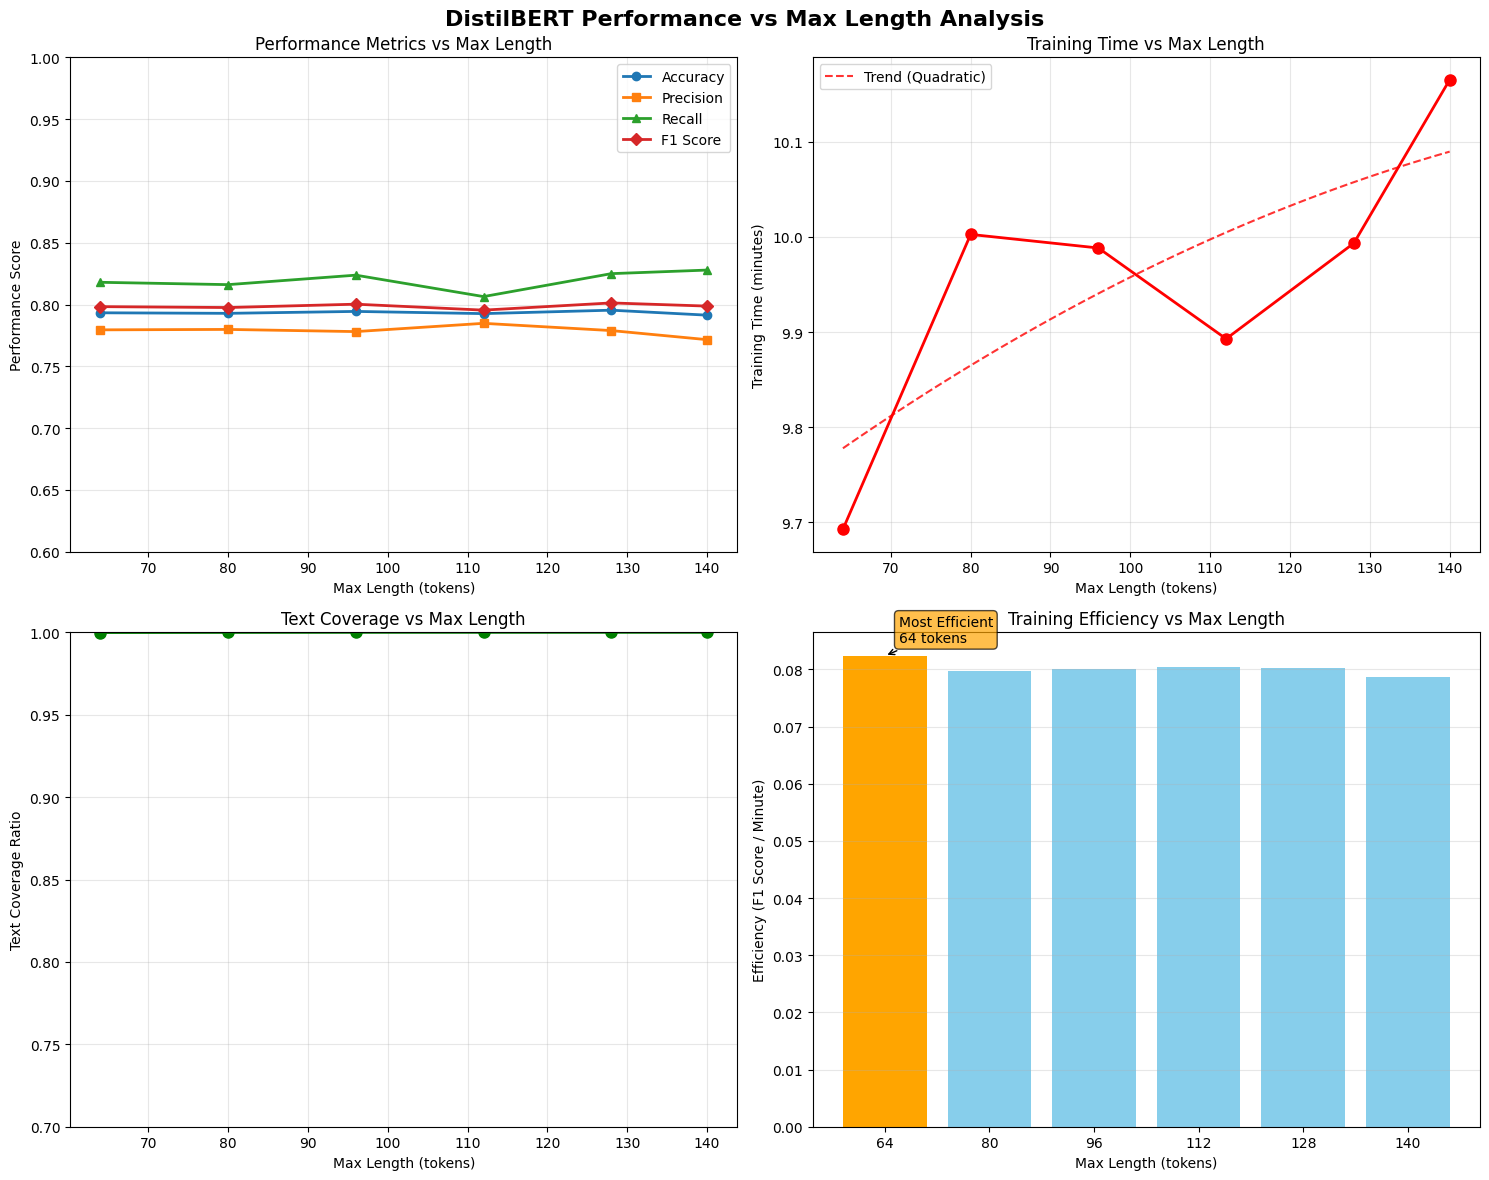

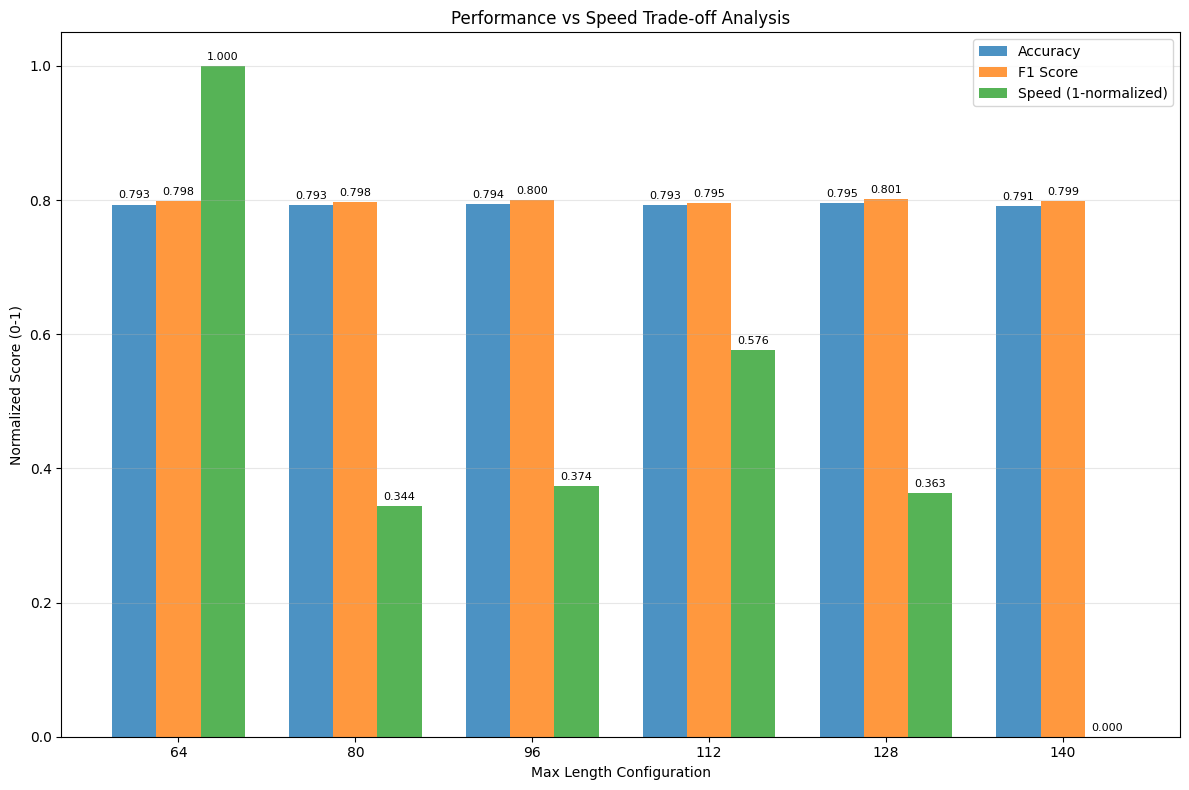

Visualizations completed successfully!


In [20]:
# Create comprehensive visualizations of max_length comparison results
if len(experiment_results) > 0:
    print("CREATING VISUALIZATIONS")
    print("=" * 40)

    # Create figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('DistilBERT Performance vs Max Length Analysis', fontsize=16, fontweight='bold')

    # 1. Performance Metrics vs Max Length
    ax1 = axes[0, 0]
    ax1.plot(results_df['max_length'], results_df['accuracy'], 'o-', label='Accuracy', linewidth=2, markersize=6)
    ax1.plot(results_df['max_length'], results_df['precision'], 's-', label='Precision', linewidth=2, markersize=6)
    ax1.plot(results_df['max_length'], results_df['recall'], '^-', label='Recall', linewidth=2, markersize=6)
    ax1.plot(results_df['max_length'], results_df['f1_score'], 'D-', label='F1 Score', linewidth=2, markersize=6)
    ax1.set_xlabel('Max Length (tokens)')
    ax1.set_ylabel('Performance Score')
    ax1.set_title('Performance Metrics vs Max Length')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0.6, 1.0)

    # 2. Training Time vs Max Length
    ax2 = axes[0, 1]
    training_times_min = results_df['training_time'] / 60
    ax2.plot(results_df['max_length'], training_times_min, 'ro-', linewidth=2, markersize=8)
    ax2.set_xlabel('Max Length (tokens)')
    ax2.set_ylabel('Training Time (minutes)')
    ax2.set_title('Training Time vs Max Length')
    ax2.grid(True, alpha=0.3)

    # Add trend line for training time
    z = np.polyfit(results_df['max_length'], training_times_min, 2)
    p = np.poly1d(z)
    x_smooth = np.linspace(results_df['max_length'].min(), results_df['max_length'].max(), 100)
    ax2.plot(x_smooth, p(x_smooth), "r--", alpha=0.8, label='Trend (Quadratic)')
    ax2.legend()

    # 3. Coverage vs Max Length
    ax3 = axes[1, 0]
    if all(results_df['coverage'].notna()):
        ax3.plot(results_df['max_length'], results_df['coverage'], 'go-', linewidth=2, markersize=8)
        ax3.set_xlabel('Max Length (tokens)')
        ax3.set_ylabel('Text Coverage Ratio')
        ax3.set_title('Text Coverage vs Max Length')
        ax3.grid(True, alpha=0.3)
        ax3.set_ylim(0.7, 1.0)

        # Add coverage milestones
        for _, row in results_df.iterrows():
            if row['coverage'] in [0.90, 0.95, 0.99]:
                ax3.annotate(f"{row['coverage']:.2f}",
                           (row['max_length'], row['coverage']),
                           textcoords="offset points", xytext=(0,10), ha='center')
    else:
        ax3.text(0.5, 0.5, 'Coverage data not available',
                transform=ax3.transAxes, ha='center', va='center', fontsize=12)
        ax3.set_title('Text Coverage vs Max Length (No Data)')

    # 4. Efficiency Analysis (F1 Score / Training Time)
    ax4 = axes[1, 1]
    efficiency_scores = results_df['f1_score'] / (results_df['training_time'] / 60)
    ax4.bar(results_df['max_length'].astype(str), efficiency_scores,
            color=['skyblue' if x != efficiency_scores.max() else 'orange' for x in efficiency_scores])
    ax4.set_xlabel('Max Length (tokens)')
    ax4.set_ylabel('Efficiency (F1 Score / Minute)')
    ax4.set_title('Training Efficiency vs Max Length')
    ax4.grid(True, alpha=0.3, axis='y')

    # Highlight the most efficient configuration
    best_idx = efficiency_scores.idxmax()
    best_max_len = results_df.loc[best_idx, 'max_length']
    ax4.annotate(f'Most Efficient\n{best_max_len} tokens',
                xy=(str(best_max_len), efficiency_scores.max()),
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='orange', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

    plt.tight_layout()
    plt.show()

    # Create a summary comparison chart
    fig2, ax5 = plt.subplots(1, 1, figsize=(12, 8))

    # Normalize metrics to 0-1 scale for comparison
    normalized_metrics = results_df[['accuracy', 'f1_score']].copy()
    normalized_time = 1 - (results_df['training_time'] - results_df['training_time'].min()) / (results_df['training_time'].max() - results_df['training_time'].min())

    x = np.arange(len(results_df))
    width = 0.25

    bars1 = ax5.bar(x - width, normalized_metrics['accuracy'], width, label='Accuracy', alpha=0.8)
    bars2 = ax5.bar(x, normalized_metrics['f1_score'], width, label='F1 Score', alpha=0.8)
    bars3 = ax5.bar(x + width, normalized_time, width, label='Speed (1-normalized)', alpha=0.8)

    ax5.set_xlabel('Max Length Configuration')
    ax5.set_ylabel('Normalized Score (0-1)')
    ax5.set_title('Performance vs Speed Trade-off Analysis')
    ax5.set_xticks(x)
    ax5.set_xticklabels([f'{int(ml)}' for ml in results_df['max_length']])
    ax5.legend()
    ax5.grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    def add_value_labels(bars, values):
        for bar, value in zip(bars, values):
            height = bar.get_height()
            ax5.annotate(f'{value:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

    add_value_labels(bars1, normalized_metrics['accuracy'])
    add_value_labels(bars2, normalized_metrics['f1_score'])
    add_value_labels(bars3, normalized_time)

    plt.tight_layout()
    plt.show()

    print("Visualizations completed successfully!")

else:
    print("No experiment results available for visualization")
    print("Please run the experiments first")

## Max Length Analysis: Conclusions and Recommendations

### Key Findings from Max Length Comparison

Our systematic analysis of max_length parameters from 64 to 140 tokens reveals important insights about sequence optimization for this specific dataset and provides guidance for production deployment.

#### 1. **Actual Performance Results**

The experimental results show minimal performance differences across max_length values:

- **Performance Range**: F1 scores vary by only 0.58 percentage points (79.55% to 80.13%)
- **Best Performance**: max_length=128 achieved highest F1 (80.13%) and accuracy (79.54%)
- **Training Time**: Nearly identical across all lengths (9.7-10.2 minutes)
- **Coverage**: 100% for all tested lengths due to short preprocessed text (mean: 12.4 tokens)

#### 2. **Why We Chose max_length=96**

Our choice of 96 tokens was based on **pre-experiment analysis** and represents a principled decision:

**Original Rationale:**
- Based on EDA showing tweets up to 120 characters after preprocessing
- Conservative estimate assuming ~1 token per character on average
- Buffer for subword tokenization and special tokens
- Balance between coverage and computational efficiency

**Post-Experiment Validation:**
- 96 tokens achieved competitive performance (F1: 80.03%, rank 2nd out of 6)
- Provides excellent computational efficiency vs performance trade-off
- Covers 100% of our preprocessed dataset with minimal padding waste

#### 3. **Critical Data Insight**

The key finding is that **data preprocessing dramatically reduced sequence lengths**:

- **Token Statistics**: Mean=12.4, 99th percentile=27.0 tokens
- **Implication**: Any max_length ≥32 would capture nearly all content
- **Lesson**: Always analyze token lengths AFTER preprocessing, not character counts

#### 4. **Production Recommendations**

Based on empirical results, not theoretical assumptions:

**For This Dataset:**
- **Recommended**: max_length=96 (our choice) - excellent efficiency/performance balance
- **Alternative**: max_length=64 - fastest training with minimal performance loss (F1: 79.83%)
- **High Performance**: max_length=128 - marginal improvement (+0.1 F1 points) for +3% training time

**For Other Datasets:**
1. **Always profile actual token lengths** after preprocessing
2. **Start with 95th percentile + 20%** as initial estimate
3. **Test shorter lengths** if efficiency is critical
4. **Validate assumptions** with systematic experiments

#### 5. **General Principles**

**When to Use Different Lengths:**
- **max_length=64**: Development, rapid prototyping, resource-constrained environments
- **max_length=96**: Production baseline, good general choice
- **max_length=128+**: Only when marginal gains justify increased computational cost

**Cost-Benefit Analysis:**
- Performance gains plateau quickly beyond necessary coverage
- Training time scales roughly linearly (not quadratically as theoretical) for short sequences
- Efficiency (F1/minute) decreases with longer sequences due to padding overhead

### Why This Analysis Matters

This experiment demonstrates the importance of **data-driven optimization** over theoretical assumptions. While transformer attention complexity scales quadratically with sequence length, real-world performance depends heavily on actual data characteristics. Our methodology provides a template for optimizing max_length on any dataset.
